In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("../Lab1/MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images,\
    mnist.test.labels

Extracting ../Lab1/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../Lab1/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../Lab1/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Lab1/MNIST_data/t10k-labels-idx1-ubyte.gz


# Utilities

In [3]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.nn.relu(
        tf.sign(probs - tf.random_uniform(tf.shape(probs))))


def draw_weights(W, shape, N, interpolation="bilinear"):
    """Vizualizacija težina
    
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    """
    image = Image.fromarray( tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/20)), 20),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, Nh):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:Nh].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
    plt.tight_layout()

# Zad 1

0 0.254909
5500 0.0230386
11000 0.0227329
16500 0.0195571
22000 0.0189286
27500 0.0204856
33000 0.0209927
38500 0.0185881
44000 0.0191046
49500 0.0178159


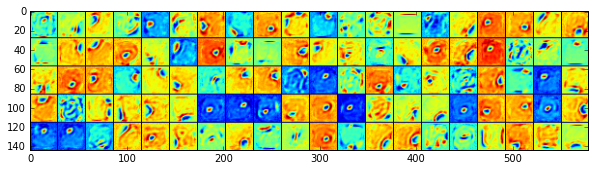

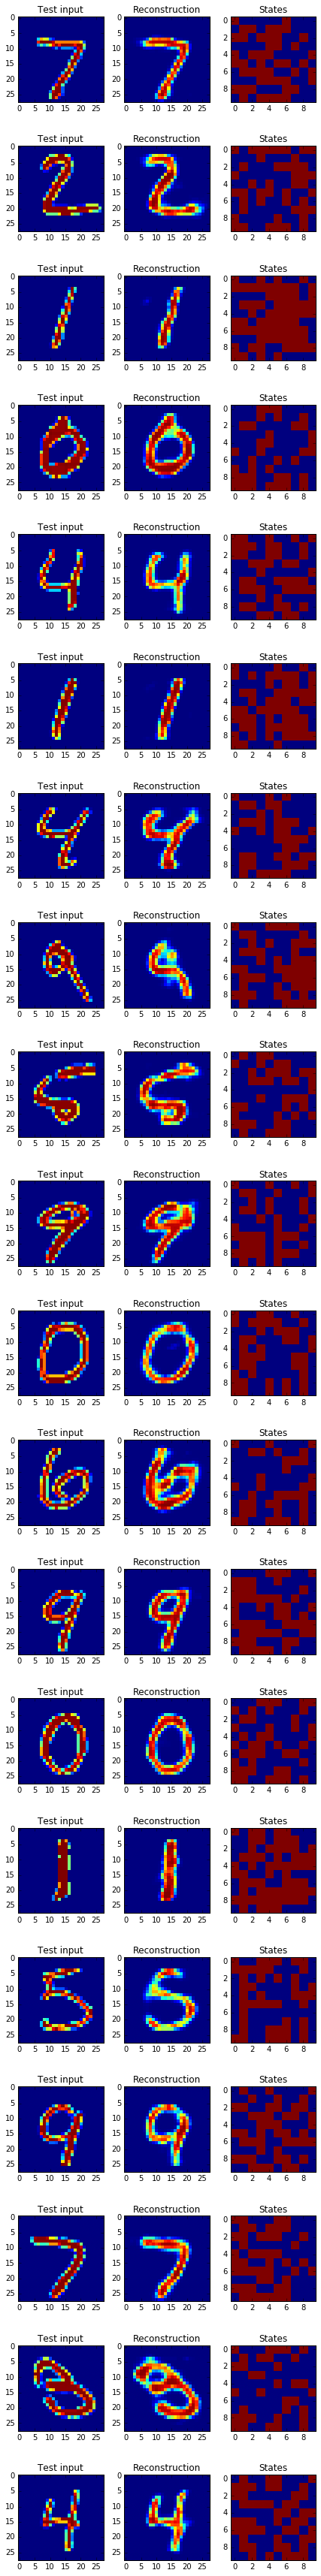

In [9]:
Nv = 784
v_shape = (28,28)
Nh = 100
h1_shape = (10,10)

gibbs_sampling_steps = 1
alpha = 0.1 # koeficijent učenja 

g1 = tf.Graph()
with g1.as_default():
    X1 = tf.placeholder("float", [None, 784])
    w1 = weights([Nv, Nh])
    vb1 = bias([Nv])
    hb1 = bias([Nh])
    
    h0_prob = tf.sigmoid(tf.matmul(X1,w1)+ hb1)  #minibatch x hidden
    h0 = sample_prob(h0_prob)
    h1 = h0

    for step in range(gibbs_sampling_steps):
        v1_prob = tf.sigmoid(tf.matmul(h1,tf.transpose(w1))+ vb1) 
        v1 = sample_prob(v1_prob)
        h1_prob = tf.sigmoid(tf.matmul(v1,w1)+ hb1)
        h1 = sample_prob(h1_prob)
    
    # pozitivna faza
    w1_positive_grad = tf.matmul(tf.transpose(X1),h0)
    
    # negativna faza
    w1_negative_grad = tf.matmul(tf.transpose(v1),h1)

    dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0])

    # operacije za osvježavanje parametara mreže - one pokreću učenje RBM-a
    update_w1 = tf.assign_add(w1, alpha * dw1)
    update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(X1 - v1_prob, 0))
    update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

    out1 = (update_w1, update_vb1, update_hb1)
    
    # rekonstrukcija ualznog vektora - koristimo vjerojatnost p(v=1)
    v1_prob = tf.sigmoid(tf.matmul(h1,tf.transpose(w1))+ vb1)
    
    err1 = X1 - v1_prob
    err_sum1 = tf.reduce_mean(err1 * err1)
    
    initialize1 = tf.initialize_all_variables()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g1) as sess:
    sess.run(initialize1)
    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum1, out1], feed_dict={X1: batch})
        
        if i%(int(total_batch/10)) == 0:
            print i, err
    
    w1s = w1.eval()
    vb1s = vb1.eval()
    hb1s = hb1.eval()
    vr, h1s = sess.run([v1_prob, h1], feed_dict={X1: teX[0:20,:]})

# vizualizacija težina
draw_weights(w1s, v_shape, Nh) 

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, Nh)

# Zad 2

0 0.0968034
5500 0.0421027
11000 0.0429445
16500 0.0376389
22000 0.0365686
27500 0.0384395
33000 0.0333833
38500 0.03168
44000 0.0322481
49500 0.0342919


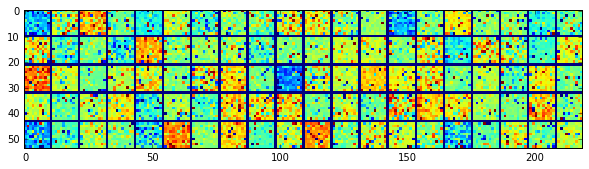

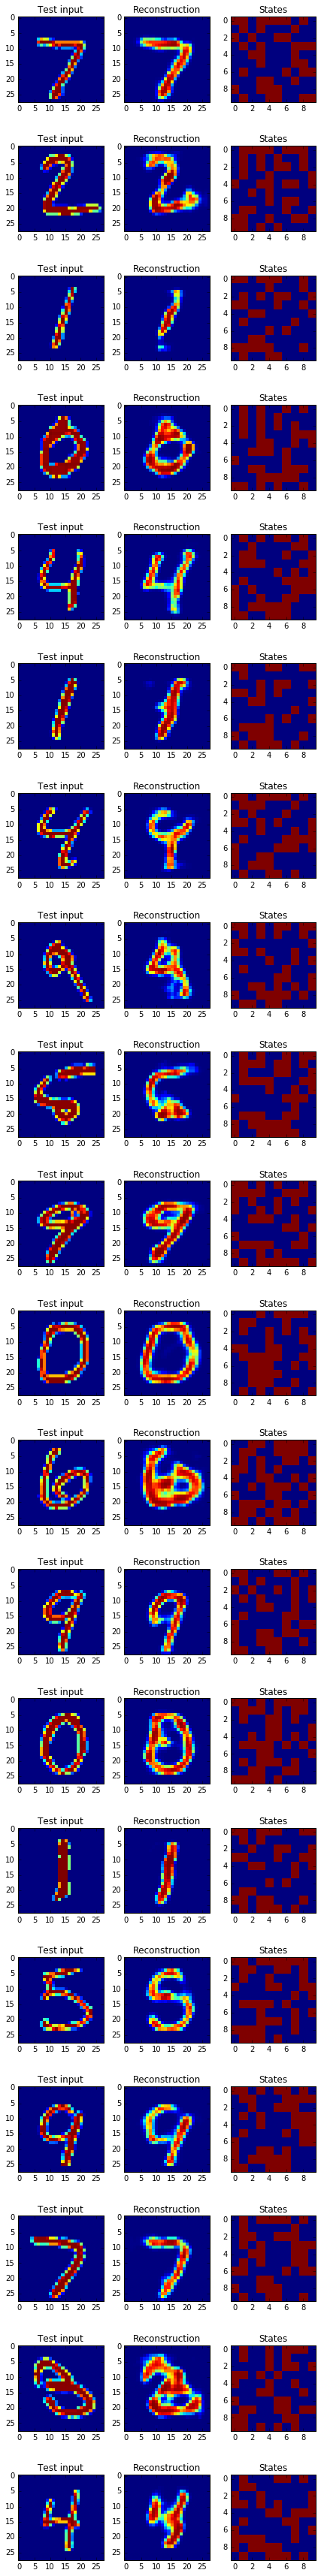

In [13]:
Nh2 = 100
h2_shape = (10,10) 
# Nh2 = 784
# h2_shape = (28,28)

gibbs_sampling_steps = 2
alpha = 0.1

g2 = tf.Graph()
with g2.as_default():
    X2 = tf.placeholder("float", [None, Nv])
    w1a = tf.Variable(w1s)
    vb1a = tf.Variable(vb1s)
    hb1a = tf.Variable(hb1s)
    w2 = weights([Nh, Nh2])
    vb2 = bias([Nh])
    hb2 = bias([Nh2])

#     dodatni zad
#     w2 = tf.Variable(w1s.transpose())
#     hb2 = bias([Nh2])
    
    # vidljivi sloj drugog RBM-a
    v2_prob  = tf.sigmoid(tf.matmul(X2,w1a)+ hb1a)
    v2 = sample_prob(v2_prob)
    # skriveni sloj drugog RBM-a
    h2_prob = tf.sigmoid(tf.matmul(v2,w2)+ hb2)
    h2 = sample_prob(h2_prob)
    h3 = h2
    
    for step in range(gibbs_sampling_steps):
        v3_prob = tf.sigmoid(tf.matmul(h3,tf.transpose(w2))+ vb2)
        v3 = sample_prob(v3_prob)
        h3_prob = tf.sigmoid(tf.matmul(v3,w2)+ hb2)
        h3 = sample_prob(h3_prob)
    
    w2_positive_grad = tf.matmul(tf.transpose(v2),h2)
    w2_negative_grad = tf.matmul(tf.transpose(v3),h3)

    dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(v2)[0])

    update_w2 = tf.assign_add(w2, alpha * dw2)
    update_vb2 = tf.assign_add(vb2, alpha * tf.reduce_mean(v2 - v3, 0))
    update_hb2 = tf.assign_add(hb2, alpha * tf.reduce_mean(h2 - h3, 0))

    out2 = (update_w2, update_vb2, update_hb2)

    # rekonsturkcija ulaza na temelju krovnog skrivenog stanja h3
    # ...
    # ...
    
    v3_prob_n = tf.sigmoid(tf.matmul(h3,tf.transpose(w2))+ vb2)
    v3_n = sample_prob(v3_prob_n)
    v4_prob = tf.sigmoid(tf.matmul(v3_n,tf.transpose(w1a))+ vb1a)
    
    err2 = X2 - v4_prob
    err_sum2 = tf.reduce_mean(err2 * err2)
    
    initialize2 = tf.initialize_all_variables()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g2) as sess:
    sess.run(initialize2)

    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum2, out2], feed_dict={X2: batch})
        
        if i%(int(total_batch/10)) == 0:
            print i, err
            
    w2s, vb2s, hb2s = sess.run([w2, vb2, hb2], feed_dict={X2: batch})
    vr2, h3s = sess.run([v4_prob, h3], feed_dict={X2: teX[0:20,:]})

# vizualizacija težina
draw_weights(w2s, h1_shape, Nh2, interpolation="nearest")

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr2, h3s, v_shape, h2_shape, Nh2)

# 3. zad

0 0.0316891
5500 0.030712
11000 0.029187
16500 0.0295886
22000 0.0295019
27500 0.0288678
33000 0.0285693
38500 0.0298622
44000 0.0272684
49500 0.0288635


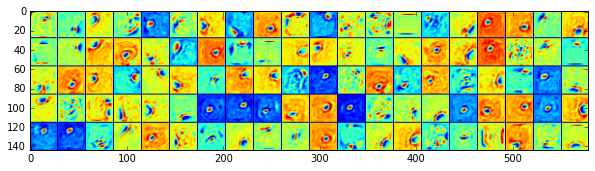

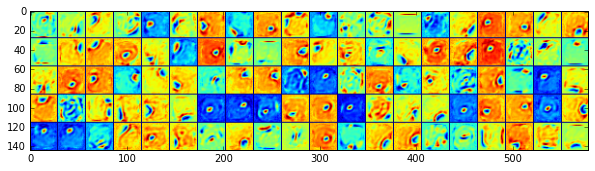

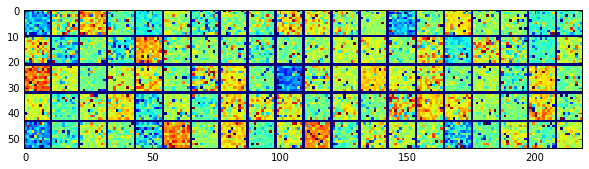

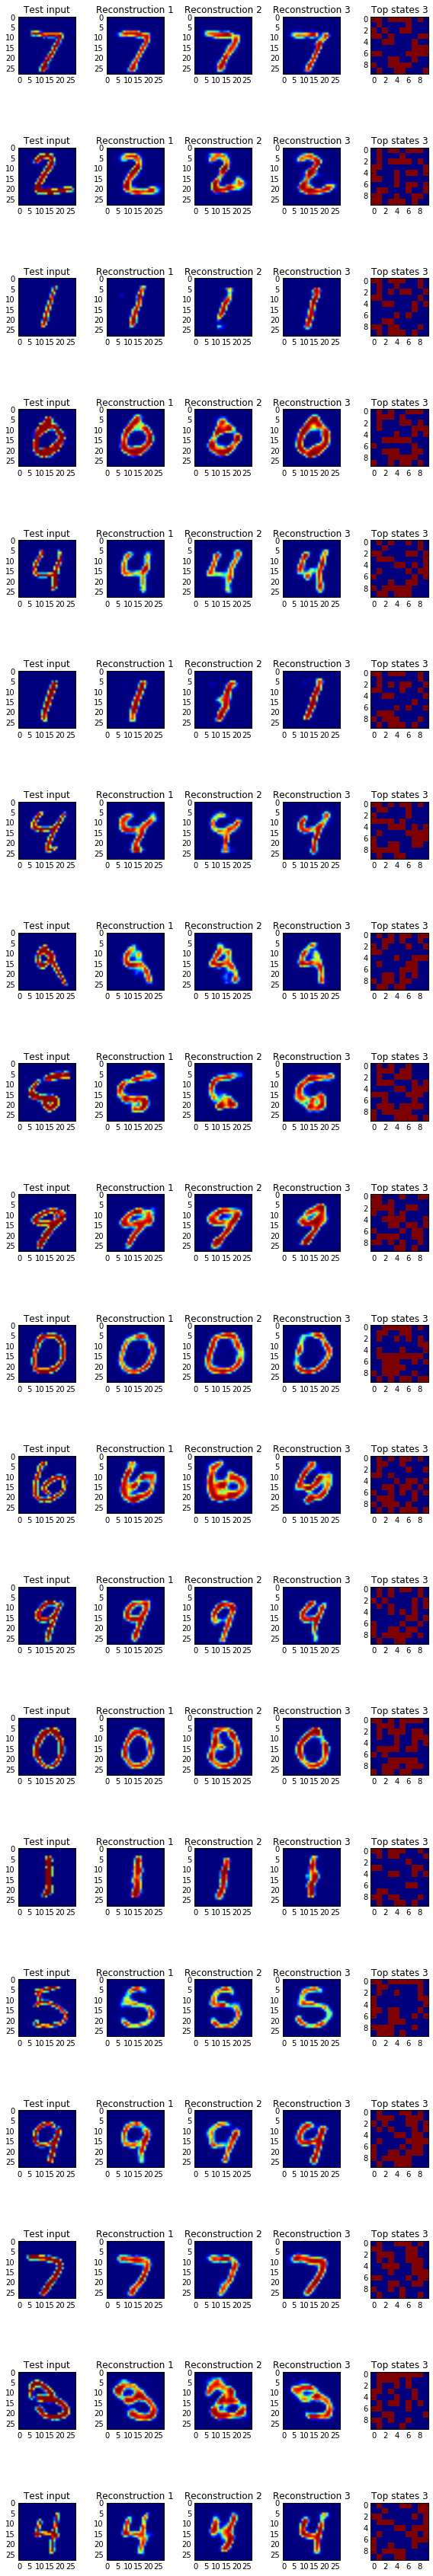

In [14]:
#
beta = 0.01

g3 = tf.Graph()
with g3.as_default():   
    X3 = tf.placeholder("float", [None, Nv])
    w1_up = tf.Variable(w1s)
    w1_down = tf.Variable(tf.transpose(w1s))
    w2a = tf.Variable(w2s)
    hb1_up = tf.Variable(hb1s)
    hb1_down = tf.Variable(vb2s)
    vb1_down = tf.Variable(vb1s)
    hb2a = tf.Variable(hb2s)
    
    # wake pass
    h1_up_prob = tf.sigmoid(tf.matmul(X3,w1_up)+ hb1_up)
    h1_up = sample_prob(h1_up_prob)# s^{(n)} u pripremi
    v1_up_down_prob = tf.sigmoid(tf.matmul(h1_up, w1_down)+ vb1_down)
    v1_up_down = sample_prob(v1_up_down_prob)# s^{(n-1)\mathit{novo}} u pripremi  
    
    
    
    # top RBM Gibs passes
    h2_up_prob = tf.sigmoid(tf.matmul(h1_up,w2a)+ hb2a)
    h2_up = sample_prob(h2_up_prob)
    h4 = h2_up
    for step in range(gibbs_sampling_steps):
        h1_down_prob = tf.sigmoid(tf.matmul(h4,tf.transpose(w2a))+ hb1_down)
        h1_down = sample_prob(h1_down_prob)
        h4_prob = tf.sigmoid(tf.matmul(h1_down,w2a)+ hb2a)
        h4 = sample_prob(h4_prob)
       
    # sleep pass
    v1_down_prob = tf.sigmoid(tf.matmul(h1_down,w1_down) + vb1_down)
    v1_down = sample_prob(v1_down_prob)# s^{(n-1)} u pripremi
    h1_down_up_prob = tf.sigmoid(tf.matmul(v1_down, w1_up) + hb1_up)
    h1_down_up = sample_prob(h1_down_up_prob)# s^{(n)\mathit{novo}} u pripremi
    
    
    # generative weights update during wake pass
    update_w1_down = tf.assign_add(w1_down, beta * tf.matmul(tf.transpose(h1_up), X3 - v1_up_down_prob) / tf.to_float(tf.shape(X3)[0]))
    update_vb1_down = tf.assign_add(vb1_down, beta * tf.reduce_mean(X3 - v1_up_down_prob, 0))
    

    # top RBM update
    w2_positive_grad = tf.matmul(tf.transpose(h1_up),h2_up)
    w2_negative_grad = tf.matmul(tf.transpose(h1_down),h4)
    dw3 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1_up)[0])
    update_w2 = tf.assign_add(w2a, beta * dw3)
    update_hb1_down = tf.assign_add(hb1_down, beta * tf.reduce_mean(h1_up - h1_down, 0))
    update_hb2 = tf.assign_add(hb2a, beta * tf.reduce_mean(h2_up - h4, 0))
    
    # recognition weights update during sleep pass
    update_w1_up = tf.assign_add(w1_up, beta * tf.matmul(tf.transpose(v1_down_prob), h1_down - h1_down_up) / tf.to_float(tf.shape(X3)[0]))
    update_hb1_up = tf.assign_add(hb1_up, beta * tf.reduce_mean(h1_down - h1_down_up, 0))###########^ #####
    
    out3 = (update_w1_down, update_vb1_down, update_w2, update_hb1_down, update_hb2, update_w1_up, update_hb1_up)
    
    err3 = X3 - v1_down_prob
    err_sum3 = tf.reduce_mean(err3 * err3)
    
    initialize3 = tf.initialize_all_variables()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g3) as sess:
    sess.run(initialize3)
    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum3, out3], feed_dict={X3: batch})
        
        if i%(int(total_batch/10)) == 0:
            print i, err
    
    w2ss, w1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = sess.run(
        [w2a, w1_up, w1_down, hb2a, hb1_up, hb1_down, vb1_down], feed_dict={X3: batch})
    vr3, h4s, h4_probs = sess.run([v1_down_prob, h4, h4_prob], feed_dict={X3: teX[0:20,:]})

# vizualizacija težina
draw_weights(w1_ups, v_shape, Nh)
draw_weights(w1_downs.T, v_shape, Nh)
draw_weights(w2ss, h1_shape, Nh2, interpolation="nearest")

# vizualizacija rekonstrukcije i stanja
Npics = 5
plt.figure(figsize=(8, 12*4))
for i in range(20):

    plt.subplot(20, Npics, Npics*i + 1)
    plt.imshow(teX[i].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Test input")
    plt.subplot(20, Npics, Npics*i + 2)
    plt.imshow(vr[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 1")
    plt.subplot(20, Npics, Npics*i + 3)
    plt.imshow(vr2[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 2")
    plt.subplot(20, Npics, Npics*i + 4)
    plt.imshow(vr3[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 3")
    plt.subplot(20, Npics, Npics*i + 5)
    plt.imshow(h4s[i][0:Nh2].reshape(h2_shape), vmin=0, vmax=1, interpolation="nearest")
    plt.title("Top states 3")
plt.tight_layout()

# 4. Zadatak

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

mnist = input_data.read_data_sets("../Lab1/MNIST_data/", one_hot=True)
n_samples = mnist.train.num_examples

learning_rate = 0.001
batch_size = 100


n_hidden_recog_1=200 # 1 sloj enkodera
n_hidden_recog_2=200 # 2 sloj enkodera
n_hidden_gener_1=200 # 1 sloj dekodera
n_hidden_gener_2=200 # 2 sloj dekodera
n_z=20 # broj skrivenih varijabli
n_input=784 # MNIST data input (img shape: 28*28)

def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state), interpolation="nearest")
        plt.colorbar()
        plt.title("States")
    plt.tight_layout()

def weight_variable(shape, name):
    """Kreiranje težina"""
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    return tf.get_variable(name, shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """Kreiranje pomaka"""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def variable_summaries(var, name):
    """Prikupljanje podataka za Tensorboard"""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

def vae_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softplus):
    """Kreiranje jednog skrivenog sloja"""
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim], layer_name + '/weights')
            variable_summaries(weights, layer_name + '/weights')
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.histogram_summary(layer_name + '/pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.histogram_summary(layer_name + '/activations', activations)
    return activations

Extracting ../Lab1/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../Lab1/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../Lab1/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Lab1/MNIST_data/t10k-labels-idx1-ubyte.gz


In [35]:
def vae_trainer(n_z, n_epochs = 10):
    tf.reset_default_graph() 

    sess = tf.InteractiveSession()        

    # definicije ulaznog tenzora
    x = tf.placeholder("float", [None, 28*28])

    # TODO definirajte enkoiderski dio
    layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
    layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

    with tf.name_scope('z'):
    # definirajte skrivene varijable i pripadajući generator šuma
        z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
        z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq',act=tf.identity)
        eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)

        z = tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
        tf.histogram_summary('z/activations', z)

    # definirajte dekoderski dio
    layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
    layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')

    # definirajte srednju vrijednost rekonstrukcije
    x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean',act=tf.identity)

    x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)

    # definirajte dvije komponente funkcije cijene
    with tf.name_scope('costs'):                         
        # komponenta funkcije cijene - unakrsna entropija
        cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x_reconstr_mean, x),1)
        # komponenta funkcije cijene - KL divergencija
        cost2 = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
        #tf.scalar_summary('cost2', cost2)
        cost = tf.reduce_mean(cost1 + cost2)   # average over batch
        tf.scalar_summary('cost', cost)

    # ADAM optimizer
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Prikupljanje podataka za Tensorboard
    merged = tf.merge_all_summaries()                        
    train_writer = tf.train.SummaryWriter('train', sess.graph)

    init = tf.initialize_all_variables()                         
    sess.run(init)

    saver = tf.train.Saver()

    for epoch in range(n_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)

        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
            avg_cost += cos / n_samples * batch_size
            
        if epoch % 10 == 0 or True:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(avg_cost)) 
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs}, 
                                  options=run_options, run_metadata=run_metadata)
            train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
            train_writer.add_summary(summary, i)

            saver.save(sess, os.path.join('train', "model.ckpt"), epoch)

    train_writer.close()
    return sess, x, x_reconstr_mean_out, z, z_mean

In [36]:
sess, x, x_reconstr_mean_out, z, z_mean = vae_trainer(20,30)

('Epoch:', '0001', 'cost=', '186.628275757')
('Epoch:', '0002', 'cost=', '137.195130851')
('Epoch:', '0003', 'cost=', '124.582180536')
('Epoch:', '0004', 'cost=', '117.886649073')
('Epoch:', '0005', 'cost=', '114.553072912')
('Epoch:', '0006', 'cost=', '112.163912021')
('Epoch:', '0007', 'cost=', '110.338873402')
('Epoch:', '0008', 'cost=', '108.975570665')
('Epoch:', '0009', 'cost=', '107.895913197')
('Epoch:', '0010', 'cost=', '107.100663105')
('Epoch:', '0011', 'cost=', '106.319302063')
('Epoch:', '0012', 'cost=', '105.702891721')
('Epoch:', '0013', 'cost=', '105.151897111')
('Epoch:', '0014', 'cost=', '104.670108518')
('Epoch:', '0015', 'cost=', '104.198808400')
('Epoch:', '0016', 'cost=', '103.819430708')
('Epoch:', '0017', 'cost=', '103.465996302')
('Epoch:', '0018', 'cost=', '103.218972015')
('Epoch:', '0019', 'cost=', '102.882467957')
('Epoch:', '0020', 'cost=', '102.571389382')
('Epoch:', '0021', 'cost=', '102.392040988')
('Epoch:', '0022', 'cost=', '102.119586570')
('Epoch:',

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x125032350>> ignored


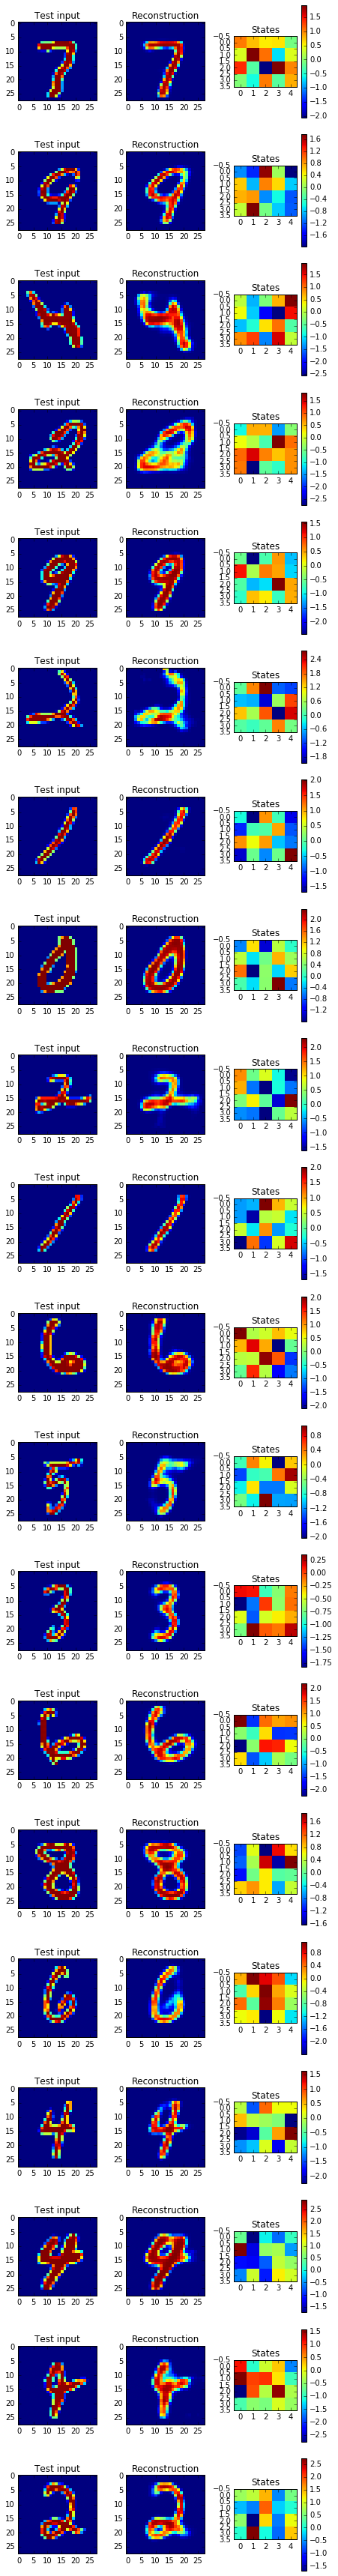

In [18]:
# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})
draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (4,5))
plt.show()

In [23]:
sess, x, x_reconstr_mean_out, z, z_mean = vae_trainer(2,30)

('Epoch:', '0001', 'cost=', '192.595570124')
('Epoch:', '0002', 'cost=', '171.438548279')
('Epoch:', '0003', 'cost=', '165.064703979')
('Epoch:', '0004', 'cost=', '161.269727534')
('Epoch:', '0005', 'cost=', '158.463058361')
('Epoch:', '0006', 'cost=', '156.278451732')
('Epoch:', '0007', 'cost=', '154.524691523')
('Epoch:', '0008', 'cost=', '153.178489519')
('Epoch:', '0009', 'cost=', '152.039949063')
('Epoch:', '0010', 'cost=', '151.028056197')
('Epoch:', '0011', 'cost=', '150.190177002')
('Epoch:', '0012', 'cost=', '149.488308827')
('Epoch:', '0013', 'cost=', '148.873437750')
('Epoch:', '0014', 'cost=', '148.353742676')
('Epoch:', '0015', 'cost=', '147.862374878')
('Epoch:', '0016', 'cost=', '147.403951416')
('Epoch:', '0017', 'cost=', '146.979338185')
('Epoch:', '0018', 'cost=', '146.703090460')
('Epoch:', '0019', 'cost=', '146.349752031')
('Epoch:', '0020', 'cost=', '146.039586071')
('Epoch:', '0021', 'cost=', '145.695312445')
('Epoch:', '0022', 'cost=', '145.391804560')
('Epoch:',

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x113e3a150>> ignored


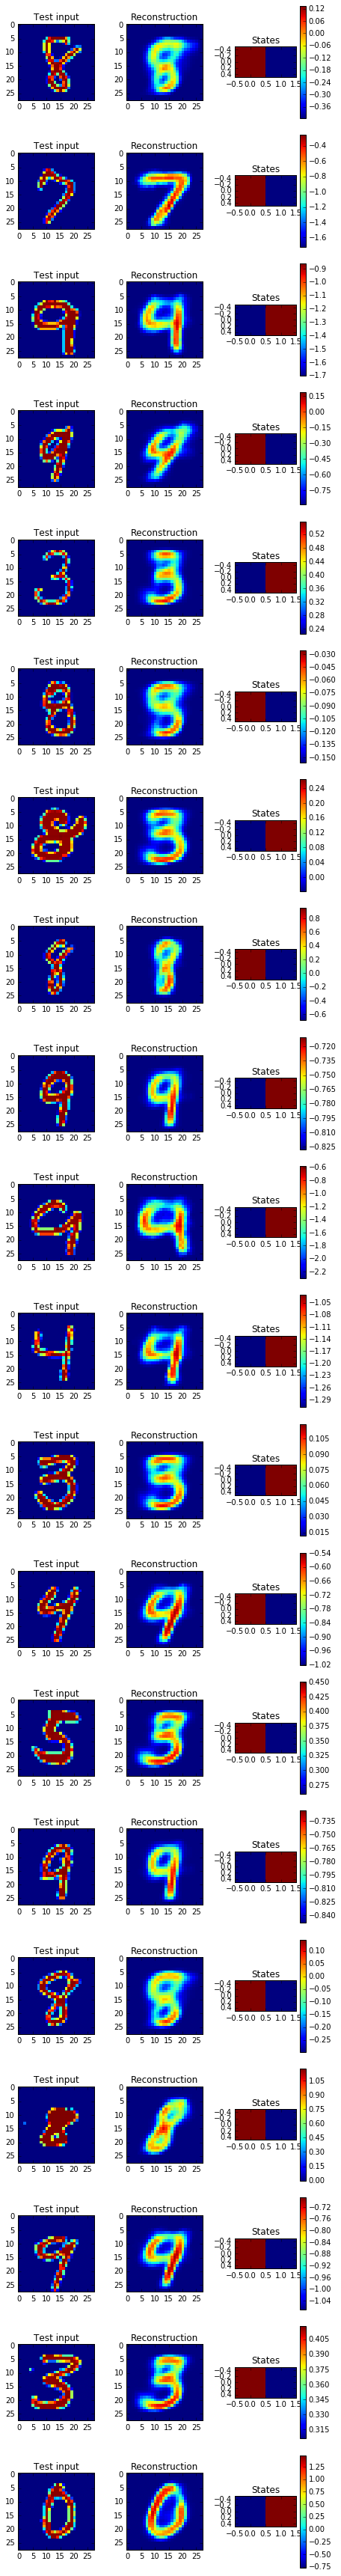

In [24]:
# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})
draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (1,2))
plt.show()

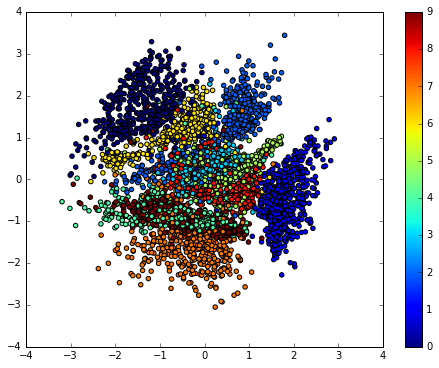

In [25]:
# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(z_mean, feed_dict={x: x_sample})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.show()

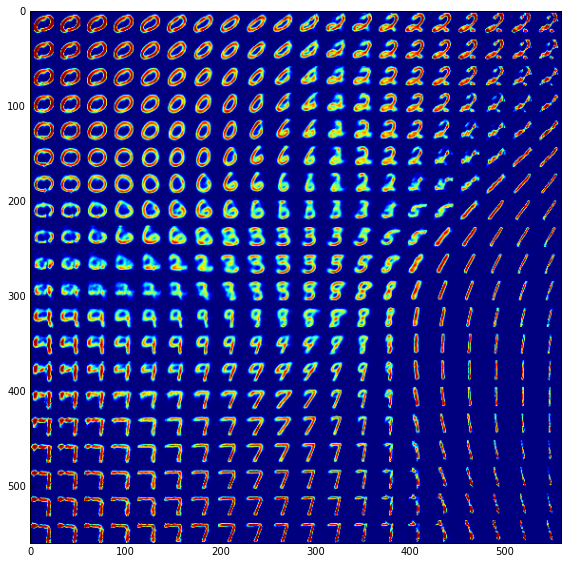

In [26]:
# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = sess.run(x_reconstr_mean_out, feed_dict={z: np.repeat(z_mu,100,0)})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()
plt.show()